In [0]:
# install pysyft for federated learning
#!pip install syft[udacity]  

In [0]:
## this is the module required for federated learning
#import syft as sy 

In [0]:
%tensorflow_version 1.x   #ensure that TF 1.x is used when TF 2.x becomes the default 

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.x   #ensure that TF 1.x is used when TF 2.x becomes the default`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import helper
import matplotlib.pyplot as plt
import numpy as np
import copy
import random

In [0]:
torch.cuda.is_available()

True

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
device

device(type='cuda')

In [0]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))
                              ])
# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw


Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw


Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw


Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw
Processing...
Done!





In [0]:
trainset

Dataset MNIST
    Number of datapoints: 60000
    Root location: /root/.pytorch/MNIST_data/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [0]:
testset

Dataset MNIST
    Number of datapoints: 10000
    Root location: /root/.pytorch/MNIST_data/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [0]:
type(trainset[0])

tuple

In [0]:
trainset[0]

In [0]:
trainset[0][0]

In [0]:
trainset[0][1]

5

In [0]:
len(trainset)

60000

In [0]:
trainset[0][0].shape

torch.Size([1, 28, 28])

In [0]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


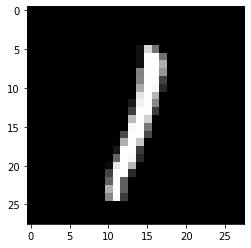

In [0]:
plt.imshow(images[1].numpy().squeeze(), cmap='Greys_r');

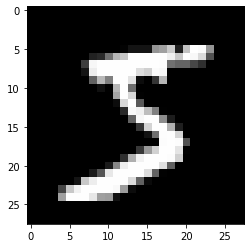

In [0]:
plt.imshow(trainset[0][0].numpy().squeeze(), cmap='Greys_r')

In [0]:
image = trainset[0][0]

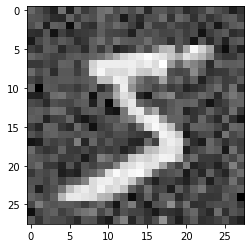

In [0]:
 plt.imshow((image+torch.Tensor(np.random.normal(0.0, 0.25, (1,28,28)))).numpy().squeeze(), cmap='Greys_r')

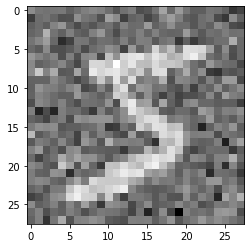

In [0]:
plt.imshow((image+torch.Tensor(np.random.normal(0.0, 0.5, (1,28,28)))).numpy().squeeze(), cmap='Greys_r')

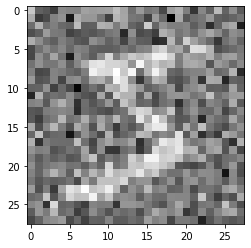

In [0]:
plt.imshow((image+torch.Tensor(np.random.normal(0.0, 0.75, (1,28,28)))).numpy().squeeze(), cmap='Greys_r')

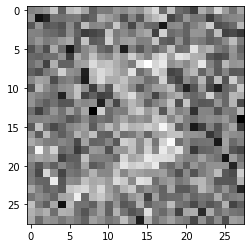

In [0]:
plt.imshow((image+torch.Tensor(np.random.normal(0.0, 1, (1,28,28)))).numpy().squeeze(), cmap='Greys_r')

# Structure of the MNIST dataset as retrieved by torchvision.datasets.MNIST
1. length of trainset: 60000 
2. each element of trainset is a tuple (image, label) where image is a 1x28x28 tensor and label is an integer in range 0-9 inclusive


# Splitting of Data
1. Same distribution with same data size: splitting data set into five parts with the same size randomly, ensuring number of images with the same label is mutually equal among the five parts

In [0]:
#create lists for sorting of data
trainset_0 = []
trainset_1 = []
trainset_2 = []
trainset_3 = []
trainset_4 = []
trainset_5 = []
trainset_6 = []
trainset_7 = []
trainset_8 = []
trainset_9 = []

In [0]:
#creates a dictionary called dictionaryData to sort the different labels
dictionaryData = {}
for k in range(10):
  dictionaryData['trainset_'+str(k)] = []
for i in range(60000):
  dictionaryData['trainset_'+str(trainset[i][1])].append(trainset[i])

In [0]:
for i in range(10):
  print ("number of " + str(i) + ": " + str(len(dictionaryData['trainset_' + str(i)])))

#based on results, we will be using 5420 of each of the labels to setup our testbed.

number of 0: 5923
number of 1: 6742
number of 2: 5958
number of 3: 6131
number of 4: 5842
number of 5: 5421
number of 6: 5918
number of 7: 6265
number of 8: 5851
number of 9: 5949


In [0]:
#creates a dictionary1 for splitting of data in case 1

dictionary1 = {}
for k in range(5):
  startIndex = 1084*k
  stopIndex = 1084*(k+1)
  dictionary1['trainset_1_'+str(k+1)] = []
  for i in range(10):
    dictionary1['trainset_1_'+str(k+1)].extend(dictionaryData['trainset_'+str(i)][startIndex:stopIndex])

In [0]:
for i in range(5):
  print(len(dictionary1['trainset_1_'+str(i+1)]))

10840
10840
10840
10840
10840


2. Different distribution with same data size. Split data set into five parts with same size, but labels are different. Let data provider 1 have 40% of label '0', 40% of label '1' and the data points with the remaining eight labels shared the remaining 20% of data provider 1's data. The rest shall be done in a same manner.

In [0]:
#creates a dictionary2 for splitting of data in case 2

dictionary2 = {}
for k in range(5):
  dictionary2['trainset_2_'+str(k+1)] = []

#create data for trainset_2_1 which has 40% of 0 and 1
dictionary2['trainset_2_1'].extend(dictionaryData['trainset_0'][0:int(10840*0.4)]) # 0: indexes 0:4336  
dictionary2['trainset_2_1'].extend(dictionaryData['trainset_1'][0:int(10840*0.4)]) # 1: indexes 0:4336
for a in range(2,10):
  dictionary2['trainset_2_1'].extend(dictionaryData['trainset_'+str(a)][0:271]) # 2-9: indexes 0:271

#create data for trainset_2_2 which has 40% of 2 and 3
dictionary2['trainset_2_2'].extend(dictionaryData['trainset_0'][int(10840*0.4):int(10840*0.4)+271]) # 0: indexes 2168:2981
dictionary2['trainset_2_2'].extend(dictionaryData['trainset_1'][int(10840*0.4):int(10840*0.4)+271]) # 1: indexes 2168:2981
dictionary2['trainset_2_2'].extend(dictionaryData['trainset_2'][271:int(10840*0.4)+271]) #2: indexes 271:4607
dictionary2['trainset_2_2'].extend(dictionaryData['trainset_3'][271:int(10840*0.4)+271]) #3: indexes 271:4607
for b in range(4,10):
  dictionary2['trainset_2_2'].extend(dictionaryData['trainset_'+str(b)][271:(271*2)]) # 4-9: indexes 271:542

#create data for trainset_2_3 which has 40% of 4 and 5
for i in range(4):
  dictionary2['trainset_2_3'].extend(dictionaryData['trainset_'+str(i)][int(10840*0.4)+271:int(10840*0.4)+271*2]) #0-3: indexes 2981:3794
dictionary2['trainset_2_3'].extend(dictionaryData['trainset_4'][(271*2):int(10840*0.4)+271*2]) #4: indexes 1626:3794
dictionary2['trainset_2_3'].extend(dictionaryData['trainset_5'][(271*2):int(10840*0.4)+271*2]) #5: indexes 1626:3794
for c in range(6,10):
  dictionary2['trainset_2_3'].extend(dictionaryData['trainset_'+str(c)][271*2:(271*3)]) # 6-9: indexes 1626:2439

#create data for trainset_2_4 which has 40% of 6 and 7
for i in range(6):
  dictionary2['trainset_2_4'].extend(dictionaryData['trainset_'+str(i)][int(10840*0.4)+271*2:int(10840*0.4)+271*3]) #0-5: indexes 3794:4607
dictionary2['trainset_2_4'].extend(dictionaryData['trainset_6'][271*3:int(10840*0.4)+271*3]) #6: indexes 2439:4607
dictionary2['trainset_2_4'].extend(dictionaryData['trainset_7'][271*3:int(10840*0.4)+271*3]) #7: indexes 2439:4607
for d in range(8,10):
  dictionary2['trainset_2_4'].extend(dictionaryData['trainset_'+str(d)][271*3:(271*4)]) # 8-9: indexes 2439:3252

#create data for trainset_2_5 which has 40% of 8 and 9
for i in range(8):
  dictionary2['trainset_2_5'].extend(dictionaryData['trainset_'+str(i)][int(10840*0.4)+271*3:int(10840*0.4)+271*4])
for e in range(8,10):
  dictionary2['trainset_2_5'].extend(dictionaryData['trainset_'+str(e)][271*4:int(10840*0.4)+271*4])

for i in range(5):
  print("trainset_2_", str(i+1), len(dictionary2['trainset_2_'+str(i+1)]))

trainset_2_ 1 10840
trainset_2_ 2 10840
trainset_2_ 3 10840
trainset_2_ 4 10840
trainset_2_ 5 10840


3. Same distribution with different data size. Split data set into five parts randomly, ratio of data size is 2:3:4:5:6. Ensure each part have the same number of images with different labels.

In [0]:
#creates a dictionary3 for splitting of data in case 3

dictionary3 = {}
for k in range(5):
  dictionary3['trainset_3_'+str(k+1)] = []
for i in range(10):
  dictionary3['trainset_3_1'].extend(dictionaryData['trainset_'+str(i)][0:271*(2)])
  dictionary3['trainset_3_2'].extend(dictionaryData['trainset_'+str(i)][271*(2):271*(5)])
  dictionary3['trainset_3_3'].extend(dictionaryData['trainset_'+str(i)][271*(5):271*(9)])
  dictionary3['trainset_3_4'].extend(dictionaryData['trainset_'+str(i)][271*(9):271*(14)])
  dictionary3['trainset_3_5'].extend(dictionaryData['trainset_'+str(i)][271*(14):271*(20)])

for i in range(5):
  print(len(dictionary3['trainset_3_'+str(i+1)]))

5420
8130
10840
13550
16260


4. Split data set into five parts with the same size randomly. Ensure number of images with the same label is mutually equal among the five parts. change the labels of different data providers randomly by 0%, 5%, 10%, 15% and 20%.

In [0]:
dictionary4 = {}

In [0]:
# deepcopy the data in dictionary1
for i in range(len(dictionary1)):
  dictionary4["trainset_4_"+str(i+1)] = copy.deepcopy(dictionary1["trainset_1_"+str(i+1)]) 

In [0]:
percentageMislabel = {"trainset_4_1": 0, "trainset_4_2": 0.05, "trainset_4_3": 0.10, "trainset_4_4": 0.15, "trainset_4_5": 0.20}

In [0]:
for i in range(len(dictionary4)):
  trainset_4_i = "trainset_4_" + str(i+1)
  numMislabel = int(percentageMislabel[trainset_4_i] * len(dictionary4[trainset_4_i]))
  print("For trainset_" + str(i) + ", number of mislabelled data is: ", numMislabel)
  indexesMislabel = random.sample(range(len(dictionary4[trainset_4_i])), numMislabel) # generate a random sample of indices without replacement)
  print(len(indexesMislabel))

  for k in indexesMislabel: 
    trueLabel = dictionary4[trainset_4_i][i][1]
    possibleMislabel = [x for x in range(10) if x != trueLabel] # list of all the possible mislabels to choose from
    dictionary4[trainset_4_i][k] = (dictionary4[trainset_4_i][k][0], random.choice(possibleMislabel)) # change the label for the k-th entry 
  print("Done", i)
    

For trainset_0, number of mislabelled data is:  0
0
Done 0
For trainset_1, number of mislabelled data is:  542
542
Done 1
For trainset_2, number of mislabelled data is:  1084
1084
Done 2
For trainset_3, number of mislabelled data is:  1626
1626
Done 3
For trainset_4, number of mislabelled data is:  2168
2168
Done 4


The label is : 9


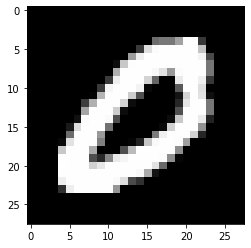

In [0]:
index = 6
plt.imshow(dictionary4["trainset_4_4"][index][0].numpy().squeeze(), cmap='Greys_r')
print("The label is :", dictionary4["trainset_4_4"][index][1])

5. Split data set into five parts with the same size. Generate 0-4x Gaussian noise where 0x is feature without noise

In [0]:
dictionary5 = {}

In [0]:
# deepcopy the data in dictionary1
for i in range(len(dictionary1)):
  dictionary5["trainset_5_"+str(i+1)] = copy.deepcopy(dictionary1["trainset_1_"+str(i+1)])

In [0]:
percentageNoise = {"trainset_5_2": 0.25, "trainset_5_3": 0.5, "trainset_5_4": 0.75, "trainset_5_5": 1.0}
#trainset_5_1 is not varied with noise

In [0]:
for i in range(1, len(dictionary5)):
  trainset_5_i = "trainset_5_" + str(i+1)
  for index in range(len(dictionary5[trainset_5_i])):
     dictionary5[trainset_5_i][index] = (dictionary5[trainset_5_i][index][0] + \
                                         torch.Tensor(np.random.normal(0.0, percentageNoise[trainset_5_i], (1,28,28))), \
                                         dictionary5[trainset_5_i][index][1])


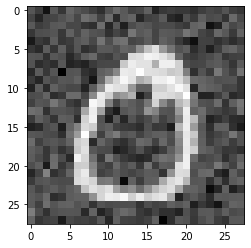

In [0]:
plt.imshow(dictionary5["trainset_5_2"][0][0].numpy().squeeze(), cmap='Greys_r')

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
root_dir = "/content/gdrive/My Drive/NTU/"
base_dir = root_dir + 'cy1400/'

In [0]:
import pickle

In [0]:
allDataFile = open(base_dir+"dictionaryData.out", "wb")
pickle.dump(dictionaryData, allDataFile)
allDataFile.close()

In [0]:
dictionary1File = open(base_dir+"dictionary1.out", "wb")
pickle.dump(dictionary1, dictionary1File)
dictionary1File.close()

dictionary2File = open(base_dir+"dictionary2.out", "wb")
pickle.dump(dictionary2, dictionary2File)
dictionary2File.close()

dictionary3File = open(base_dir+"dictionary3.out", "wb")
pickle.dump(dictionary3, dictionary3File)
dictionary3File.close()

dictionary4File = open(base_dir+"dictionary4.out", "wb")
pickle.dump(dictionary4, dictionary4File)
dictionary4File.close()

dictionary5File = open(base_dir+"dictionary5.out", "wb")
pickle.dump(dictionary5, dictionary5File)
dictionary5File.close()

In [0]:
dictionary2File = open(base_dir+"dictionary2.out", "wb")
pickle.dump(dictionary2, dictionary2File)
dictionary2File.close()

In [0]:
dictionary2['trainset_2_1'][0][1]

0

In [0]:
### check dictionary2
for i in range(5):
  theTrain = dictionary2["trainset_2_"+str(i+1)]
  total = len(theTrain)
  count = {}
  for k in range(10):
    count[k] = 0
  for item in theTrain:
    key = item[1]
    count[key] += 1
  print('\n',"trainset_2_"+str(i+1), sep='')
  for i in range(10):
    print("percentage of", i, "is: ", count[i]/total*100)

    


trainset_2_1
percentage of 0 is:  40.0
percentage of 1 is:  40.0
percentage of 2 is:  2.5
percentage of 3 is:  2.5
percentage of 4 is:  2.5
percentage of 5 is:  2.5
percentage of 6 is:  2.5
percentage of 7 is:  2.5
percentage of 8 is:  2.5
percentage of 9 is:  2.5

trainset_2_2
percentage of 0 is:  2.5
percentage of 1 is:  2.5
percentage of 2 is:  40.0
percentage of 3 is:  40.0
percentage of 4 is:  2.5
percentage of 5 is:  2.5
percentage of 6 is:  2.5
percentage of 7 is:  2.5
percentage of 8 is:  2.5
percentage of 9 is:  2.5

trainset_2_3
percentage of 0 is:  2.5
percentage of 1 is:  2.5
percentage of 2 is:  2.5
percentage of 3 is:  2.5
percentage of 4 is:  40.0
percentage of 5 is:  40.0
percentage of 6 is:  2.5
percentage of 7 is:  2.5
percentage of 8 is:  2.5
percentage of 9 is:  2.5

trainset_2_4
percentage of 0 is:  2.5
percentage of 1 is:  2.5
percentage of 2 is:  2.5
percentage of 3 is:  2.5
percentage of 4 is:  2.5
percentage of 5 is:  2.5
percentage of 6 is:  40.0
percentage o